<a href="https://colab.research.google.com/github/Juan8078/Tomato-classification/blob/main/training_tomato_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [31]:
import tensorflow as tf
print("GPU Available: ", tf.config.list_physical_devices('GPU'))

GPU Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


###Setup Dataset

In [32]:
from google.colab import drive
import os

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [33]:
base_dir = "/content/drive/My Drive/Colab Notebooks/"
!ls "/content/drive/My Drive/Colab Notebooks/"

training_dir = os.path.join(base_dir, "projects/tomato_project/datasets/version_1/training")
validation_dir = os.path.join(base_dir, "projects/tomato_project/datasets/version_1/validation")

'8 FEBRUARI_training_tomato_classification.ipynb'	    projects
'Copy of 8 FEBRUARI_training_tomato_classification.ipynb'   version_11-05-2024
'Copy of training_tomato_classification.ipynb'		    version_1-20240417T014308Z-001
'Load_hasil training.ipynb'				    version-2-2024-04-20


In [34]:
train_damaged = os.path.join(training_dir, 'damaged/')
train_old = os.path.join(training_dir, 'old/')
train_ripe = os.path.join(training_dir, 'ripe/')
train_unripe = os.path.join(training_dir, 'unripe/')
print("Count init train tomato")
print("count of image damaged : ", len(os.listdir(train_damaged)))
print("count of image old : ", len(os.listdir(train_old)))
print("count of image ripe : ", len(os.listdir(train_ripe)))
print("count of image unripe : ", len(os.listdir(train_unripe)))

print("\n")

validation_damaged = os.path.join(validation_dir, 'damaged/')
validation_old = os.path.join(validation_dir, 'old/')
validation_ripe = os.path.join(validation_dir, 'ripe/')
validation_unripe = os.path.join(validation_dir, 'unripe/')
print("Count init validation tomato")
print("count of image damaged : ", len(os.listdir(validation_damaged)))
print("count of image old : ", len(os.listdir(validation_old)))
print("count of image ripe : ", len(os.listdir(validation_ripe)))
print("count of image unripe : ", len(os.listdir(validation_unripe)))

Count init train tomato
count of image damaged :  380
count of image old :  380
count of image ripe :  380
count of image unripe :  380


Count init validation tomato
count of image damaged :  95
count of image old :  95
count of image ripe :  95
count of image unripe :  95


###Pre Processing

In [35]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import regularizers

In [36]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=False,
    shear_range=0.2,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1
)

valid_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    horizontal_flip=False,
    shear_range=0.2,
    fill_mode='nearest',
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.1
)

In [37]:
train_generator = train_datagen.flow_from_directory(
    training_dir,
    batch_size = 32,
    target_size=(256,256),
    class_mode="categorical",
    seed=46
)

validation_generator = valid_datagen.flow_from_directory(
    validation_dir,
    batch_size = 32,
    target_size=(256,256),
    class_mode="categorical",
    seed=46
)

Found 1520 images belonging to 4 classes.
Found 380 images belonging to 4 classes.


In [38]:
label_map=(train_generator.class_indices)
print(label_map)

{'damaged': 0, 'old': 1, 'ripe': 2, 'unripe': 3}


In [39]:
# optional untuk batas jika 99% stop pelatihan
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if(logs.get('accuracy') > 0.99):
      print('\nAkurasi mencapai 99%')
      self.model.stop_training = True

callbacks = myCallback()

In [40]:
model = tf.keras.models.Sequential([
    #first layer
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', padding='same', kernel_initializer='he_normal', input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    #second layer
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'), tf.keras.layers.MaxPooling2D(2,2),
    #third layer
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'), tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'), tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', padding='same', kernel_initializer='he_normal'), tf.keras.layers.MaxPooling2D(2,2),
    #flatten dropout
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.3),
    #fully connected layers
    tf.keras.layers.Dense(128, activity_regularizer=regularizers.l2(0.001), activation='relu'),
    tf.keras.layers.Dropout(0.6),
    tf.keras.layers.Dense(4, activation='softmax')
])

In [41]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 128, 128, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 32)      4640      
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 64, 64, 64)        18496     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 32, 32, 64)       

###Core Convolutional Neural Network (CNN) Training

In [42]:
adam = Adam(learning_rate=0.001)

model.compile(
    loss='categorical_crossentropy',
    optimizer=adam,
    metrics=['accuracy']
)

In [43]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

Epoch 1/100
48/48 [==============================] - 105s 2s/step - loss: 1.1662 - accuracy: 0.4658 - val_loss: 0.7090 - val_accuracy: 0.7342
Epoch 2/100
48/48 [==============================] - 47s 976ms/step - loss: 0.6710 - accuracy: 0.7112 - val_loss: 0.4603 - val_accuracy: 0.7816
Epoch 3/100
48/48 [==============================] - 48s 996ms/step - loss: 0.4909 - accuracy: 0.7684 - val_loss: 0.4429 - val_accuracy: 0.7605
Epoch 4/100
48/48 [==============================] - 49s 1s/step - loss: 0.4651 - accuracy: 0.7947 - val_loss: 0.4207 - val_accuracy: 0.7763
Epoch 5/100
48/48 [==============================] - 48s 1s/step - loss: 0.4183 - accuracy: 0.8336 - val_loss: 0.3381 - val_accuracy: 0.8763
Epoch 6/100
48/48 [==============================] - 49s 1s/step - loss: 0.3553 - accuracy: 0.8763 - val_loss: 0.2959 - val_accuracy: 0.8974
Epoch 7/100
48/48 [==============================] - 47s 986ms/step - loss: 0.3742 - accuracy: 0.8520 - val_loss: 0.3339 - val_accuracy: 0.8947
Epo

###Training Result

In [44]:
from sklearn.metrics import classification_report
test_generator = ImageDataGenerator(rescale=1./255)
test_data_generator=test_generator.flow_from_directory(
    # validation_dir,
    '/content/drive/MyDrive/Colab Notebooks/projects/tomato_project/datasets/version_1/validation',
    target_size = (256,256),
    batch_size=30,
    shuffle=False
)

Found 380 images belonging to 4 classes.


In [45]:
label_map=(train_generator.class_indices)
print(label_map)

{'damaged': 0, 'old': 1, 'ripe': 2, 'unripe': 3}


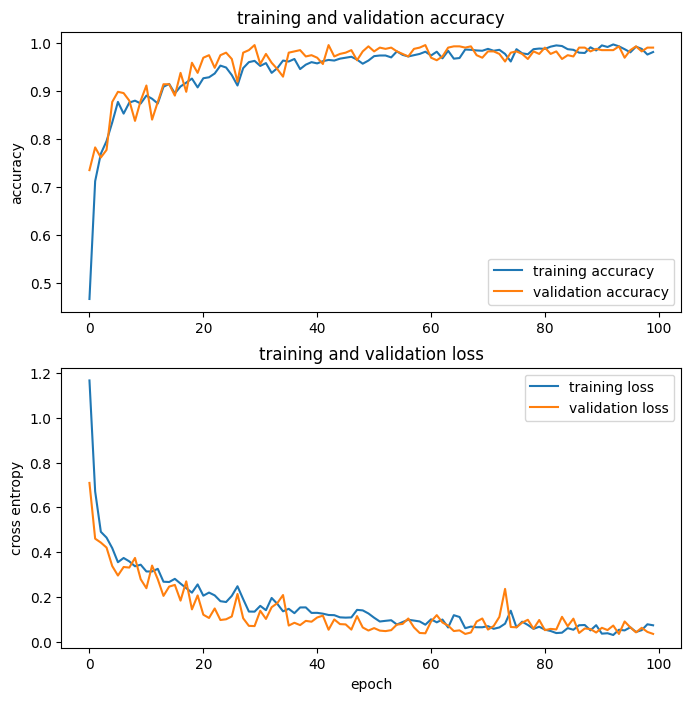

In [46]:
import tensorflow as tf
tf.keras.models.save_model(model, 'modelcnn_final.keras')

import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.legend(loc='lower right')
plt.ylabel('accuracy')
plt.title('training and validation accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.legend(loc='upper right')
plt.ylabel('cross entropy')
plt.title('training and validation loss')
plt.xlabel('epoch')
plt.show()

In [47]:
model.evaluate(validation_generator)

12/12 [==============================] - 10s 784ms/step - loss: 0.0361 - accuracy: 0.9868


[0.03612453117966652, 0.9868420958518982]

In [57]:
# save model
model.save('/content/drive/My Drive/Colab Notebooks/projects/tomato_project/models/12Mei5.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [58]:
# save model
model.save('/content/drive/My Drive/Colab Notebooks/projects/tomato_project/models/12Mei5.keras')

0 : damaged
1 : old
2 : ripe
3 : unripe
13/13 [==============================] - 4s 302ms/step


Text(0.5, 58.7222222222222, 'Prediction')

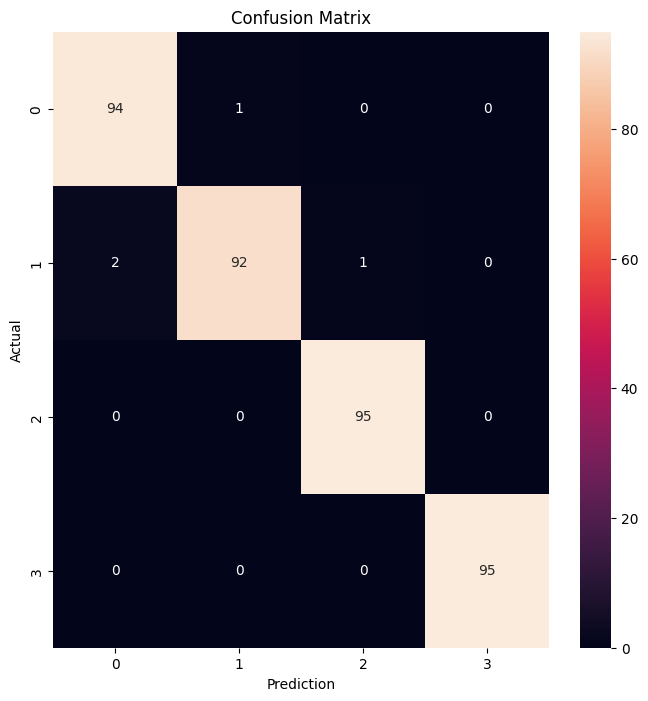

In [59]:
import sklearn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

for x in label_map:
      print(label_map[x],":",x)

prediction = model.predict(test_data_generator)
y_pred=np.argmax(prediction,axis=1)

plt.figure(figsize=(8,8))
sns.heatmap(confusion_matrix(test_data_generator.classes,y_pred),annot=True)
plt.title("Confusion Matrix")
plt.ylabel("Actual")
plt.xlabel("Prediction")

In [51]:
label_map=(train_generator.class_indices)
print(label_map)

{'damaged': 0, 'old': 1, 'ripe': 2, 'unripe': 3}


In [52]:
from sklearn.metrics import classification_report
print(classification_report(test_data_generator.classes,y_pred))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98        95
           1       0.99      0.97      0.98        95
           2       0.99      1.00      0.99        95
           3       1.00      1.00      1.00        95

    accuracy                           0.99       380
   macro avg       0.99      0.99      0.99       380
weighted avg       0.99      0.99      0.99       380



###Error Analysis

In [53]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

y_pred = model.predict(validation_generator)
y_true = validation_generator.classes

confusion_mtx = confusion_matrix(y_true, np.argmax(y_pred, axis=1))
print(confusion_mtx)

report = classification_report(y_true, np.argmax(y_pred, axis=1))
print(report)

12/12 [==============================] - 9s 790ms/step
[[24 20 27 24]
 [19 30 19 27]
 [30 19 27 19]
 [23 24 23 25]]
              precision    recall  f1-score   support

           0       0.25      0.25      0.25        95
           1       0.32      0.32      0.32        95
           2       0.28      0.28      0.28        95
           3       0.26      0.26      0.26        95

    accuracy                           0.28       380
   macro avg       0.28      0.28      0.28       380
weighted avg       0.28      0.28      0.28       380



###Test Real Case


Saving Copy of damagedTrain10(4).jpg to Copy of damagedTrain10(4).jpg
1/1 [==============================] - 0s 91ms/step


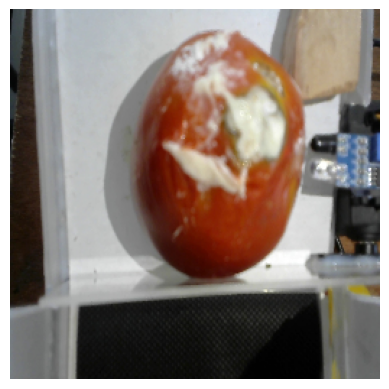

Gambar Copy of damagedTrain10(4).jpg termasuk ke dalam Tomat kelas 0: damaged
Confidence: 100.00%


In [54]:
from google.colab import files
from keras.preprocessing import image
import numpy as np

uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    predictions = model.predict(x)
    class_index = np.argmax(predictions, axis=1)[0]

    class_label = list(label_map.keys())[list(label_map.values()).index(class_index)]

    # Mendapatkan nilai probabilitas tertinggi
    confidence = np.max(predictions) * 100  # Mengonversi ke persentase

    # Menampilkan gambar
    plt.imshow(img)
    plt.axis('off')
    plt.show()

    print(f'Gambar {fn} termasuk ke dalam Tomat kelas {class_index}: {class_label}')
    print(f'Confidence: {confidence:.2f}%')

###Test Case Output G-Drive

In [55]:
import time
from google.colab import files
from keras.preprocessing import image
import numpy as np
import json

uploaded = files.upload()

for fn in uploaded.keys():
    path = fn
    img = image.load_img(path, target_size=(256, 256))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0

    start_time = time.time()

    predictions = model.predict(x)
    class_index = np.argmax(predictions, axis=1)[0]
    class_label = list(label_map.keys())[list(label_map.values()).index(class_index)]

    end_time = time.time()
    elapsed_time = end_time - start_time
    class_index = int(class_index)

    accuracy = np.max(predictions) * 100

    data = {
        "class_index": class_index,
        "class_label": class_label,
        "accuracy": f'{accuracy:.2f}%',
        "elapsed_time": f'{elapsed_time:.4f} seconds'
    }

    json_data = json.dumps(data, indent=4)
    print(json_data)

Saving Copy of damagedTrain17.jpg to Copy of damagedTrain17.jpg
1/1 [==============================] - 0s 32ms/step
{
    "class_index": 0,
    "class_label": "damaged",
    "accuracy": "100.00%",
    "elapsed_time": "0.1032 seconds"
}


In [28]:
from google.colab import drive
import json

file_path = "/content/drive/My Drive/Colab Notebooks/projects/tomato_project/output/result.json"

with open(file_path, 'w') as json_file:
    json.dump(data, json_file)

print(f'File {file_path} \n berhasil diunggah ke Google Drive.')

File /content/drive/My Drive/Colab Notebooks/projects/tomato_project/output/result.json 
 berhasil diunggah ke Google Drive.


In [29]:
from keras.preprocessing import image
import numpy as np
import json

file_path = "/content/drive/MyDrive/Colab Notebooks/projects/tomato_project/input/May_09_2024_17_43_44.jpg"
img = image.load_img(file_path, target_size=(256, 256))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

predictions = model.predict(x)
class_index = np.argmax(predictions, axis=1)[0]
class_label = list(label_map.keys())[list(label_map.values()).index(class_index)]

start_time = time.time()
end_time = time.time()
elapsed_time = end_time - start_time

accuracy = np.max(predictions) * 100

data = {
    "class_index": int(class_index),
    "class_label": class_label,
    "accuracy": f'{accuracy:.2f}%',
    "elapsed_time": f'{elapsed_time:.4f} seconds'
}

json_data = json.dumps(data, indent=4)
print(json_data)

from google.colab import drive
import json

file_path = "/content/drive/My Drive/Colab Notebooks/projects/tomato_project/output/result.json"

with open(file_path, 'w') as json_file:
    json.dump(data, json_file)

print(f'File {file_path} \n berhasil diunggah ke Google Drive.')


1/1 [==============================] - 0s 19ms/step
{
    "class_index": 2,
    "class_label": "ripe",
    "accuracy": "99.99%",
    "elapsed_time": "0.0000 seconds"
}
File /content/drive/My Drive/Colab Notebooks/projects/tomato_project/output/result.json 
 berhasil diunggah ke Google Drive.


In [56]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
